# 1. DATA PREPARATION

## 1.1. IMPORT

In [2]:
# install packages
#!pip install pandas
#!pip install numpy
#!pip install sklearn
#!pip install xgboost
#!pip install hyperopt

In [1]:
# load packages
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import mean_absolute_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from matplotlib import pylab as plt
import pickle

In [2]:
# warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# import data
data = pd.read_csv("../../data/data_full.csv")

## 1.2. PREPARATION

In [4]:
# check the data
data.head()

,ID,SalOrg,year,month,y,lag_1,lag_2,lag_3,lag_4,lag_5,...,SubFct,DP_FAMILY_CODE,MktABC,Business,Gamma,ItemCat,PRODUCT_STATUS,Plant,DC,season
0,0.0,0,2013,1,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0,1,0,3,2,0,2,1,3
1,0.0,0,2013,1,16.0,4.0,1.0,0.0,30.0,0.0,...,2,21,3,0,13,2,4,2,1,3
2,0.0,0,2013,1,0.0,0.0,0.0,0.0,0.0,0.0,...,2,5,0,3,6,2,4,1,1,3
3,0.0,0,2013,1,2.0,0.0,0.0,0.0,0.0,0.0,...,2,0,1,3,13,2,0,2,1,3
4,0.0,0,2013,1,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0,1,0,11,2,0,0,1,3


In [5]:
# check the data
print(data.shape)
print(data.columns)

(3108708, 41)
Index(['ID', 'SalOrg', 'year', 'month', 'y', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'LT', 'MOQ', 'ROP', 'SafetyStk', 'Gross_Weight',
       'Length', 'Width', 'Height', 'Volume', 'CBO_CBO_Qty_Shortage',
       'Comp_reference_number', 'Name_Of_Competitor', 'PL', 'SUBRANGE',
       'SubFct', 'DP_FAMILY_CODE', 'MktABC', 'Business', 'Gamma', 'ItemCat',
       'PRODUCT_STATUS', 'Plant', 'DC', 'season'],
      dtype='object')


In [6]:
# count number of missings
missings = data.isnull().sum()
missings[missings > 0]

y        116028
lag_1     77352
lag_2     38676
dtype: int64

In [7]:
# drop lags 1 and 2
data = data.drop(["lag_1", "lag_2"], axis = 1)
data.shape

(3108708, 39)

In [8]:
# remove observations if lags 3-12 are zeros
lags = [col for col in data.columns if "lag" in col]
lags = data[lags]
lags = lags.sum(axis = 1)
lags = lags[lags == 0]
nuls = data.ix[lags.index]
nuls = list(nuls[nuls.ID == 0].index)
data = data.drop(nuls)
data.shape

(1471518, 39)

In [9]:
# transform the target
data.y = np.log(1 + data.y)

In [34]:
# partitioning the data: round 1
X_known = data[-data.y.isnull()]
y_known = data[-data.y.isnull()].y
X_unknown = data[data.y.isnull()]
y_unknown = data[ data.y.isnull()].y

# partition the data: round 2
X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size = 0.30, random_state = 108)

# prind data dimensions
print(X_known.shape)
print(X_unknown.shape)
print(X_train.shape)
print(X_test.shape)

(1355490, 39)
(116028, 39)
(948843, 39)
(406647, 39)


In [35]:
### ADDITIONAL FEATURES (STATS)

## 1. TRAIN - TEST DATA

# compute additional variables: month
train_stats = X_train.groupby(["month"]).y.agg(["min", "max", "mean", "std"])
train_stats.columns = ["mon_" + str(col) for col in train_stats.columns]
train_stats["month"] = train_stats.index
X_train = X_train.merge(train_stats, how = "left")
X_test  = X_test.merge(train_stats, how = "left")
print(X_train.shape)
print(X_test.shape)

# compute additional variables: country
train_stats = X_train.groupby(["SalOrg"]).y.agg(["min", "max", "mean", "std"])
train_stats.columns = ["con_" + str(col) for col in train_stats.columns]
train_stats["SalOrg"] = train_stats.index
X_train = X_train.merge(train_stats, how = "left")
X_test  = X_test.merge(train_stats, how = "left")
print(X_train.shape)
print(X_test.shape)

# compute additional variables: month-country
train_stats = X_train.groupby(["month", "SalOrg"]).y.agg(["min", "max", "mean", "std"])
train_stats.columns = ["mon_con_" + str(col) for col in train_stats.columns]
train_stats["month"] = train_stats.index.get_level_values("month")
train_stats["SalOrg"] = train_stats.index.get_level_values("SalOrg")
X_train = X_train.merge(train_stats, how = "left")
X_test  = X_test.merge(train_stats, how = "left")
print(X_train.shape)
print(X_test.shape)


## 2. KNOWN - UNKNOWN DATA

# compute additional variables: month
known_stats = X_known.groupby(["month"]).y.agg(["min", "max", "mean", "std"])
known_stats.columns = ["mon_" + str(col) for col in known_stats.columns]
known_stats["month"] = known_stats.index
X_known = X_known.merge(known_stats, how = "left")
X_unknown  = X_unknown.merge(known_stats, how = "left")
print(X_known.shape)
print(X_unknown.shape)

# compute additional variables: country
known_stats = X_known.groupby(["SalOrg"]).y.agg(["min", "max", "mean", "std"])
known_stats.columns = ["con_" + str(col) for col in known_stats.columns]
known_stats["SalOrg"] = known_stats.index
X_known = X_known.merge(known_stats, how = "left")
X_unknown  = X_unknown.merge(known_stats, how = "left")
print(X_known.shape)
print(X_unknown.shape)

# compute additional variables: month-country
known_stats = X_known.groupby(["month", "SalOrg"]).y.agg(["min", "max", "mean", "std"])
known_stats.columns = ["mon_con_" + str(col) for col in known_stats.columns]
known_stats["month"] = known_stats.index.get_level_values("month")
known_stats["SalOrg"] = known_stats.index.get_level_values("SalOrg")
X_known = X_known.merge(known_stats, how = "left")
X_unknown  = X_unknown.merge(known_stats, how = "left")
print(X_known.shape)
print(X_unknown.shape)

(948843, 43)
(406647, 43)
(948843, 47)
(406647, 47)
(948843, 51)
(406647, 51)
(948843, 55)
(406647, 55)
(948843, 59)
(406647, 59)
(948843, 63)
(406647, 63)
(1355490, 43)
(116028, 43)
(1355490, 47)
(116028, 47)
(1355490, 51)
(116028, 51)
(1355490, 55)
(116028, 55)
(1355490, 59)
(116028, 59)
(1355490, 63)
(116028, 63)


In [36]:
# remove labels from X
X_unknown = X_unknown.drop("y", axis = 1)
X_known   = X_known.drop("y", axis = 1)
X_train   = X_train.drop("y", axis = 1)
X_test    = X_test.drop("y", axis = 1)

# print data dimensions
print(X_known.shape)
print(X_unknown.shape)
print(X_train.shape)
print(X_test.shape)

(1355490, 62)
(116028, 62)
(948843, 62)
(406647, 62)


## 2.1. PARAMETER TUNING

In [37]:
# task parameters
task_pars = {
             "objective"   : "reg:linear",
             "eval_metric" : "mae",
             "nthread"     : 8,
             "silent"      : 1, 
             "seed"        : 108   
            }

In [38]:
# FUNCTION 1: parameter space
def optimize(trials, task_params, max_evals = 100):
    
    # set up the parameter space
    space = {
             "eta"             : hp.quniform("eta", 0.005, 0.5, 0.005),
             "gamma"           : hp.quniform("gamma", 0.3, 1, 0.01),
             "max_depth"       : hp.quniform("max_depth", 3, 15, 1),
             "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
             "colsample_bytree": hp.quniform("colsample_bytree", 0.3, 1, 0.05),
             "subsample"       : hp.quniform("subsample", 0.6, 1, 0.05),
             "num_round"       : 100,
            }
    
    # add task parameters
    space.update(task_params)
    
    # find the best combination
    best = fmin(score, space, algo = tpe.suggest, trials = trials, max_evals = max_evals)
    
    # return results
    return best

In [39]:
# FUNCTION 2: performing the tuning
def score(params):
    
    # display information
    print("Training with the following parameters:")
    print(params)
    
    # convert to integer
    params["max_depth"] = int(params["max_depth"])
    params["num_round"] = int(params["num_round"])
    params["seed"]      = int(params["seed"])

    # transform matrices
    dtrain = xgb.DMatrix(X_train.drop("ID", axis = 1), label = y_train)
    dvalid = xgb.DMatrix(X_test.drop("ID",  axis = 1), label = y_test)
    
    # train the model
    model = xgb.train(params, dtrain, params["num_round"])
    
    # predict and score
    predictions = model.predict(dvalid)
    score = mean_absolute_error(y_test, predictions)
    
    # display information
    print("Score: {0}".format(round(score, 5)))
    print("\n---------------------------------------------\n")
    return {'loss': score, 'status': STATUS_OK}

In [123]:
# performing the tuning trials
trials = Trials()
best_params = optimize(trials, task_params = task_pars, max_evals = 10)

Training with the following parameters:
{'colsample_bytree': 0.6000000000000001, 'eta': 0.41000000000000003, 'eval_metric': 'mae', 'gamma': 0.66, 'max_depth': 5.0, 'min_child_weight': 3.0, 'nthread': 8, 'num_round': 100, 'objective': 'reg:linear', 'seed': 108, 'silent': 1, 'subsample': 0.8}
Score: 0.48409

---------------------------------------------

Training with the following parameters:
{'colsample_bytree': 0.9, 'eta': 0.17500000000000002, 'eval_metric': 'mae', 'gamma': 0.9400000000000001, 'max_depth': 4.0, 'min_child_weight': 2.0, 'nthread': 8, 'num_round': 100, 'objective': 'reg:linear', 'seed': 108, 'silent': 1, 'subsample': 0.6000000000000001}
Score: 0.49099

---------------------------------------------

Training with the following parameters:
{'colsample_bytree': 0.8, 'eta': 0.455, 'eval_metric': 'mae', 'gamma': 0.67, 'max_depth': 7.0, 'min_child_weight': 5.0, 'nthread': 8, 'num_round': 100, 'objective': 'reg:linear', 'seed': 108, 'silent': 1, 'subsample': 0.75}
Score: 0.479

In [124]:
# adding task parameters
best_params.update(task_pars)

# converting to integer
best_params["max_depth"] = int(best_params["max_depth"])
best_params["seed"]      = int(best_params["seed"])
best_params

{'colsample_bytree': 0.45,
 'eta': 0.17500000000000002,
 'eval_metric': 'mae',
 'gamma': 0.47000000000000003,
 'max_depth': 7,
 'min_child_weight': 6.0,
 'nthread': 8,
 'objective': 'reg:linear',
 'seed': 108,
 'silent': 1,
 'subsample': 0.75}

In [125]:
# saving the best params
pickle.dump(best_params, open("../files/full_xgb_par_10iter_transform_extravar.p", "wb"))

In [40]:
# loading the best params
best_params = pickle.load(open("../files/full_xgb_par_10iter_transform_extravar.p", "rb" ))
best_params

{'colsample_bytree': 0.45,
 'eta': 0.17500000000000002,
 'eval_metric': 'mae',
 'gamma': 0.47000000000000003,
 'max_depth': 7,
 'min_child_weight': 6.0,
 'nthread': 8,
 'objective': 'reg:linear',
 'seed': 108,
 'silent': 1,
 'subsample': 0.75}

## 2.2. PERFORMING CROSS-VALIDATION

In [41]:
# transforming dataframes
d_known   = xgb.DMatrix(X_known.drop("ID",   axis = 1), label = y_known)
d_unknown = xgb.DMatrix(X_unknown.drop("ID", axis = 1))

In [42]:
# CV settings
num_rounds = 100
num_folds  = 4
verbose    = 1

In [ ]:
# performing cross-validation
cv = xgb.cv(best_params, d_known, verbose_eval = verbose, stratified = False,
            nfold = num_folds, show_stdv = False, num_boost_round = num_rounds)
print("Optimal number of trees: " + str(1 + cv["test-mae-mean"].argmin()))
print("Estimated error value: "   + str(round(cv.loc[cv["test-mae-mean"].argmin()]["test-mae-mean"], 4)))

## 2.3. TRAINING THE OPTIMAL MODEL

In [43]:
# train the optimal model
xgb_best = xgb.train(best_params, d_known, num_boost_round = cv["test-mae-mean"].argmin())

In [44]:
# list feature names
features = list(X_known.columns[1:])

# function for exporting
def create_feature_map(features):
    outfile = open("../files/xgb.fmap", "w")
    i = 0
    for feat in features:
        outfile.write("{0}\t{1}\tq\n".format(i, feat))
        i = i + 1
    outfile.close()
    
# export feature names as a file
create_feature_map(features)

Text(0,0.5,'')

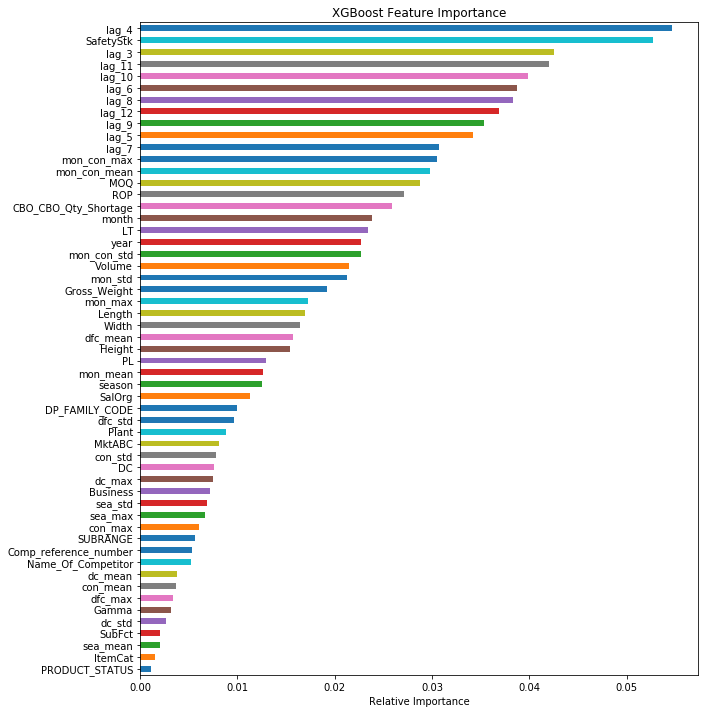

In [45]:
# extract feature importance
import operator
importance = xgb_best.get_fscore(fmap = "../files/xgb.fmap")
importance = sorted(importance.items(), key = operator.itemgetter(1))

# store in a dataframe
var_imp = pd.DataFrame(importance, columns = ["feature", "fscore"])
var_imp["fscore"] = var_imp["fscore"] / var_imp["fscore"].sum()

# create a plot
plt.figure()
var_imp.plot(kind = "barh", x = "feature", y = "fscore", legend = False, figsize = (10, 12))
plt.title("XGBoost Feature Importance")
plt.xlabel("Relative Importance")
plt.ylabel("")

In [46]:
# predicting the unknown data
pred = xgb_best.predict(d_unknown)
pred

array([1.7921478 , 1.0804379 , 0.23201117, ..., 0.3815813 , 1.3315353 ,
       0.11148471], dtype=float32)

In [47]:
# transfrom predictions
pred = np.exp(pred) - 1

## 2.4. CREATING SUBMISSION

In [48]:
# creating the data frame
subm = pd.concat([X_unknown["ID"].reset_index(drop = True), 
                  pd.Series(pred).reset_index(drop = True)], axis = 1)
subm.columns = ["ID", "demand"]
subm["ID"] = subm["ID"].astype("int")
subm = subm.sort_values(by = "ID")

In [49]:
# smart edit 1: removing negative values
subm.demand[subm.demand < 0] = 0

In [50]:
# smart edit 2: impute zeros if all lags are zeros
lags = [col for col in X_unknown.columns if "lag" in col]
lags = X_unknown[lags]
lags = lags.sum(axis = 1)
lags = lags[lags == 0]
null_ids = list(X_unknown.ix[lags.index].ID.astype("int"))
subm.demand[subm.ID.isin(null_ids)] = 0

In [51]:
# exporting
subm.to_csv("../submissions/red3_xgb_10it_100cv_transform_extravar.csv", index = False)
subm.head()

,ID,demand
0,0,5.002330
1,1,1.945969
2,2,0.261134
3,3,1.281755
4,4,0.472273
